# BigEarthNet Analysis

## Data Preparation

In [1]:
import torch
import rasterio
import kornia as K
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import umap
import umap.plot
from torchgeo.datasets import BigEarthNet
from torch.utils.data import DataLoader

e:\Programming\DOFA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
COMB_MEAN = [166.36275909, 88.45542715, 114.1099739 , 114.81779093, 126.63977424,  84.33539309,
        97.84789168, 103.94461911, 101.435633  ,  72.32804172,
        56.66528851]
COMB_STD = [64.83126309, 43.07350145, 77.84352553, 69.96844919, 67.42465279, 64.57022983, 61.72545487,
       61.34187099, 60.29744676, 47.88519516, 42.55886798]

def swap_bands(x):
    indices = [0,1,5,4,3,6,7,8,9,12,13]
    return x[:,indices,:,:]

class DataAugmentation(torch.nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.transform = torch.nn.Sequential(
            K.augmentation.RandomResizedCrop(size=(224,224), scale=(0.2,1.0)),
            K.augmentation.Normalize(mean=mean,std=std)
        )
    @torch.no_grad()
    def forward(self,x):
        # Bands: VV, VH, B4, B3, B2, B5, B6, B7, B8, B11, B12
        # x.shape = [32, 14, 120, 120]
        # x: VV, VH, B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12
        x = swap_bands(x)
        x_out = self.transform(x)
        return x_out
    
transform = DataAugmentation(mean=COMB_MEAN,std=COMB_STD)

In [3]:
# Test dimension swapping
input = torch.zeros(1,14,1,1)
for i in range(14):
    input[0,i,0,0] = i - 1
transformed = swap_bands(input)
print(input.squeeze())
print(transformed.squeeze())

tensor([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])
tensor([-1.,  0.,  4.,  3.,  2.,  5.,  6.,  7.,  8., 11., 12.])


In [4]:
from models_dwv import vit_large_patch16
from models_dwv import vit_base_patch16

large = True

if large:
    check_point = torch.load('./checkpoints/DOFA_ViT_large_e100.pth')
    vit_model = vit_large_patch16()
else:
    check_point = torch.load('./checkpoints/DOFA_ViT_base_e100.pth')
    vit_model = vit_base_patch16()
vit_model = vit_model.cuda()
vit_model.eval()
msg = vit_model.load_state_dict(check_point, strict=False)
# missing_keys=['fc_norm.weight', 'fc_norm.bias', 'head.weight', 'head.bias'], unexpected_keys=['mask_token', 'norm.weight', 'norm.bias', 'projector.weight', 'projector.bias']

## Running model on images

In [5]:
dataset_path = "data/bigearthnet/"

In [6]:
dataset = BigEarthNet(
    root=dataset_path,
    split="train",  # or "val", "test"
    bands="all",
    num_classes=43,  # or 19 depending on the task
    download=False,
    checksum=False
)

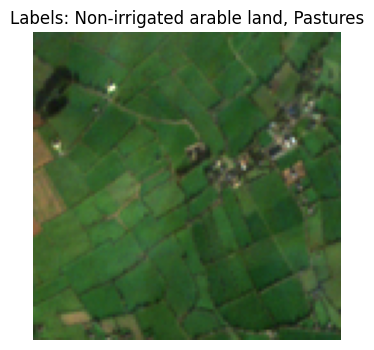

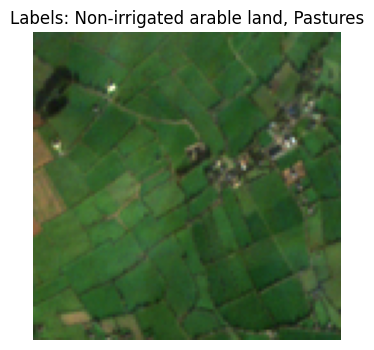

In [7]:
dataset.plot(dataset.__getitem__(2000))

In [8]:
BATCH_SIZE = 32

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,  # Adjust based on your GPU memory
    shuffle=True,
    num_workers=8
)
len(dataloader)

8428

In [9]:
C = 11  # can be 2,3,4,6,9,12,13,202 or any number if you can provide the wavelengths of them
wavelengths = [3.75, 3.75, 0.665, 0.56, 0.49, 0.705, 0.74, 0.783, 0.842, 1.61, 2.19]
tensor_size = 1024 if large else 768

In [ ]:
out_feat = torch.zeros(len(dataset), tensor_size)
out_logits = torch.zeros(len(dataset),  45)
save_labels = torch.zeros(len(dataset), 43)

with torch.no_grad():
    for index, batch in enumerate(tqdm(dataloader)):
        images = batch["image"]
        labels = batch["label"]
        preprocessed_images = transform(images)
        preprocessed_images = preprocessed_images.to('cuda')
        pos = index * BATCH_SIZE
        size = preprocessed_images.shape[0]
        out_feat[pos:pos+size] = vit_model.forward_features(preprocessed_images, wave_list=wavelengths).to('cpu')
        out_logits[pos:pos+size] = vit_model.forward(preprocessed_images, wave_list=wavelengths).to('cpu')
        save_labels[pos:pos+size] = labels
        del preprocessed_images

100%|██████████| 8428/8428 [1:14:22<00:00,  1.89it/s]


In [34]:
suffix = "large" if large else "base"
torch.save(out_logits, f'./features/s1s2-logits-train-bigearthnet-v1-{suffix}.pth')
torch.save(out_feat, f'./features/s1s2-feat-train-bigearthnet-v1-{suffix}.pth')
torch.save(save_labels, f'./features/s1s2-labels-train-bigearthnet-v1-{suffix}.pth')

In [35]:
test_dataset = BigEarthNet(
    root=dataset_path,
    split="test",  # or "val", "test"
    bands="all",
    num_classes=43,  # or 19 depending on the task
    download=False,
    checksum=False
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,  # Adjust based on your GPU memory
    shuffle=True,
    num_workers=8
)
len(test_dataloader)

3934

In [36]:
tensor_size = 1024 if large else 768
out_test_feat = torch.zeros(len(test_dataset), tensor_size)
out_test_logits = torch.zeros(len(test_dataset),  45)
save_test_labels = torch.zeros(len(test_dataset), 43)

with torch.no_grad():
    for index, batch in enumerate(tqdm(test_dataloader)):
        images = batch["image"]
        labels = batch["label"]
        preprocessed_images = transform(images)
        preprocessed_images = preprocessed_images.to('cuda')
        pos = index * BATCH_SIZE
        size = preprocessed_images.shape[0]
        out_test_feat[pos:pos+size] = vit_model.forward_features(preprocessed_images, wave_list=wavelengths).to('cpu')
        out_test_logits[pos:pos+size] = vit_model.forward(preprocessed_images, wave_list=wavelengths).to('cpu')
        save_test_labels[pos:pos+size] = labels
        del preprocessed_images

100%|██████████| 3934/3934 [28:49<00:00,  2.28it/s]


In [37]:
suffix = "large" if large else "base"
torch.save(out_test_logits, f'./features/s1s2-logits-test-bigearthnet-v1-{suffix}.pth')
torch.save(out_test_feat, f'./features/s1s2-feat-test-bigearthnet-v1-{suffix}.pth')
torch.save(save_test_labels, f'./features/s1s2-labels-test-bigearthnet-v1-{suffix}.pth')

In [11]:
val_dataset = BigEarthNet(
    root=dataset_path,
    split="val",
    bands="all",
    num_classes=43,  # or 19 depending on the task
    download=False,
    checksum=False
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,  # Adjust based on your GPU memory
    shuffle=True,
    num_workers=8
)
print(len(val_dataloader))
print(len(val_dataset))
print(len(val_dataset) / BATCH_SIZE)

3867
123723
3866.34375


In [12]:
tensor_size = 1024 if large else 768
out_val_feat = torch.zeros(len(val_dataset), tensor_size)
out_val_logits = torch.zeros(len(val_dataset),  45)
save_val_labels = torch.zeros(len(val_dataset), 43)

with torch.no_grad():
    for index, batch in enumerate(tqdm(val_dataloader)):
        images = batch["image"]
        labels = batch["label"]
        preprocessed_images = transform(images)
        preprocessed_images = preprocessed_images.to('cuda')
        pos = index * BATCH_SIZE
        size = preprocessed_images.shape[0]
        out_val_feat[pos:pos+size] = vit_model.forward_features(preprocessed_images, wave_list=wavelengths).to('cpu')
        out_val_logits[pos:pos+size] = vit_model.forward(preprocessed_images, wave_list=wavelengths).to('cpu')
        save_val_labels[pos:pos+size] = labels
        del preprocessed_images

  0%|          | 0/3867 [00:00<?, ?it/s]

e:\Programming\DOFA\.venv\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 3867/3867 [54:20<00:00,  1.19it/s] 


In [13]:
suffix = "large" if large else "base"
torch.save(out_val_logits, f'./features/s1s2-logits-val-bigearthnet-v1-{suffix}.pth')
torch.save(out_val_feat, f'./features/s1s2-feat-val-bigearthnet-v1-{suffix}.pth')
torch.save(save_val_labels, f'./features/s1s2-labels-val-bigearthnet-v1-{suffix}.pth')